# Pass Heat Maps
This code explores a heat map only for Sweden's most dangerous player (defined by which player was most involved in dangerous passes).

In [38]:
import matplotlib.pyplot as plt
from mplsoccer import Pitch, Sbopen, VerticalPitch
import pandas as pd

# Finding the most dangerous player
To start, we will plot a countplot of every player on Sweden to find who was most involved in dangerous passes. We will start by parsing the data to find dangerous passes

In [39]:
# open data
parser = Sbopen()
df_match = parser.match(competition_id = 72, season_id = 30)
#get list of games by team name both home and away
match_ids = df_match.loc[(df_match["home_team_name"] == "Sweden Women's") | (df_match["away_team_name"] == "Sweden Women's")]["match_id"].tolist()

# find number of games
num_games = len(match_ids)

In [40]:
#declare an empty dataframe
danger_passes = pd.DataFrame()
team = "Sweden Women's"
for idx in match_ids:
    #open the event data from this game 
    df = parser.event(idx)[0]
    for period in [1, 2]:
        #keep only accurate passes by England that were not set pieces in this period
        mask_pass = (df.team_name == team) & (df.type_name == "Pass") & (df.outcome_name.isnull()) & (df.period == period) & (df.sub_type_name.isnull()) 
        #keep only necessary columns
        passes = df.loc[mask_pass, ["x", "y", "end_x", "end_y", "minute", "second", "player_name"]]
        #keep only Shots by England in this period
        mask_shot = (df.team_name == team) & (df.type_name == "Shot") & (df.period == period)
        #keep only necessary columns
        shots = df.loc[mask_shot, ["minute", "second"]]
        #convert time to seconds
        shot_times = shots['minute']*60+shots['second']
        shot_window = 15  
        #find starts of the window
        shot_start = shot_times - shot_window
        #condition to avoid negative shot starts
        shot_start = shot_start.apply(lambda i: i if i>0 else (period-1)*45)
        #convert to seconds
        pass_times = passes['minute']*60+passes['second']
        #check if pass is in any of the windows for this half
        pass_to_shot = pass_times.apply(lambda x: True in ((shot_start < x) & (x < shot_times)).unique())
        
        #keep only danger passes
        danger_passes_period = passes.loc[pass_to_shot]
        #concatenate dataframe with a previous one to keep danger passes from the whole tournament
        danger_passes = pd.concat([danger_passes, danger_passes_period], ignore_index = True)
danger_passes.head()

/opt/anaconda3/lib/python3.12/site-packages/mplsoccer/statsbomb.py:513: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['timestamp'] = pd.to_datetime(df['timestamp']).dt.time
/opt/anaconda3/lib/python3.12/site-packages/mplsoccer/statsbomb.py:513: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['timestamp'] = pd.to_datetime(df['timestamp']).dt.time
/opt/anaconda3/lib/python3.12/site-packages/mplsoccer/statsbomb.py:513: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['timestamp'] = pd.to_datetime(df['timestamp']).dt.time
/opt/anaconda3/lib/python3.12/site-packages/mplsocce

,x,y,end_x,end_y,minute,second,player_name
0,68.0,51.1,61.4,40.1,17,41,Nilla Fischer
1,61.4,36.6,65.1,24.3,17,43,Linda Brigitta Sembrant
2,67.1,23.3,77.6,6.4,17,45,Sara Caroline Seger
3,77.0,6.4,109.8,8.5,17,47,Magdalena Lilly Eriksson
4,116.5,22.4,109.1,46.2,17,53,Emma Stina Blackstenius


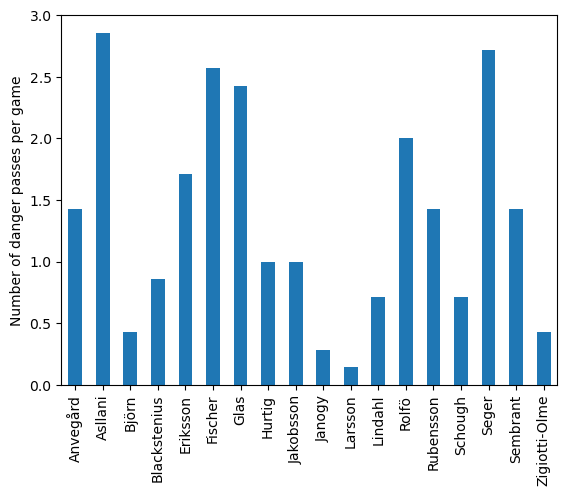

In [41]:
# keep last names 
danger_passes["player_name"] = danger_passes["player_name"].apply(lambda x: str(x).split()[-1])
#count passes by player and normalize them
pass_count = danger_passes.groupby(["player_name"]).x.count()/num_games
#make a histogram
ax = pass_count.plot.bar(pass_count)
#make legend
ax.set_xlabel("")
ax.set_ylabel("Number of danger passes per game")
plt.show()

# Making the heat map
Based on the histogram above, we see the Asllani was Sweden's most dangerous player, so we can make a heat map with only her passes.

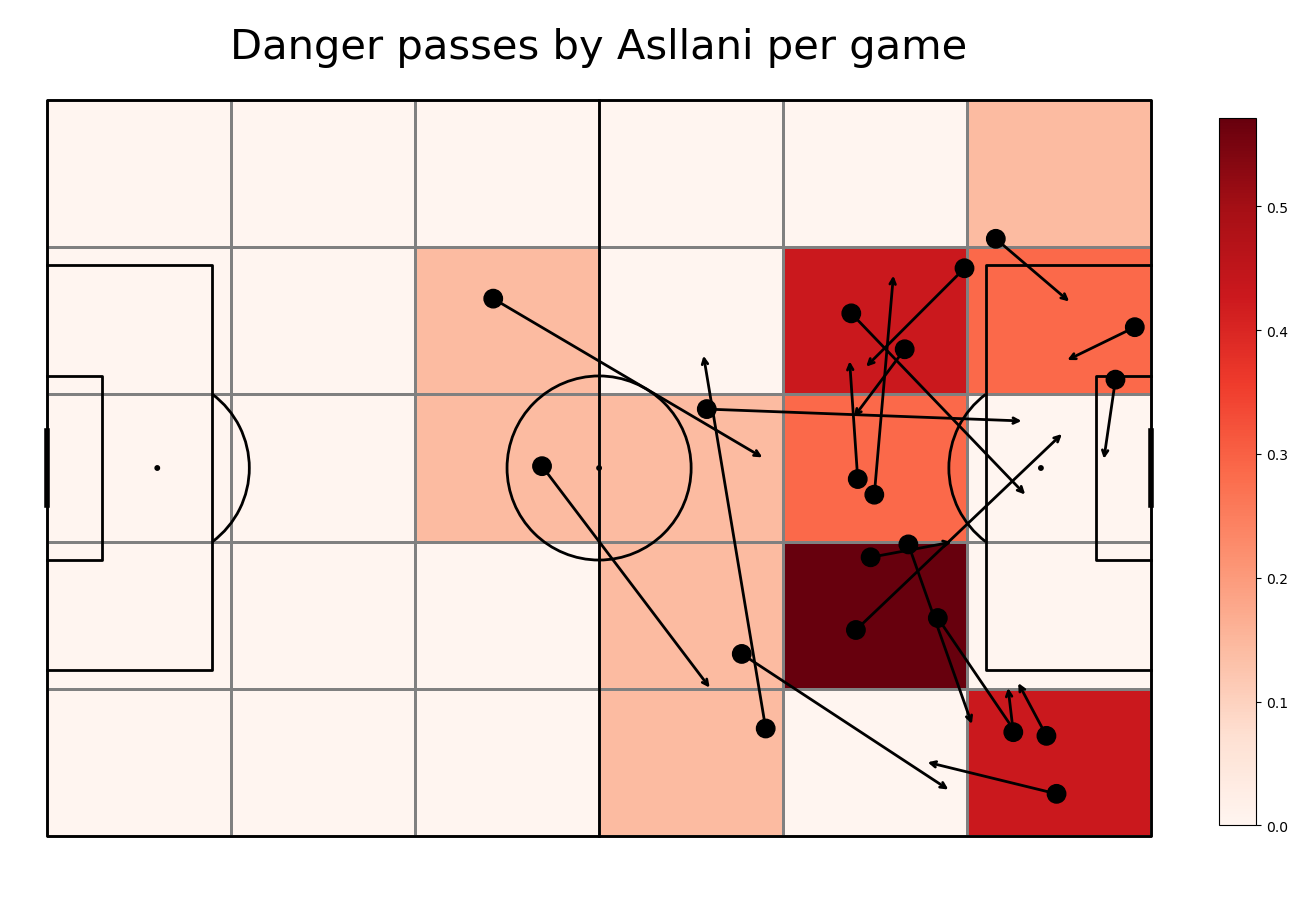

In [42]:
#plot vertical pitch
pitch = Pitch(line_zorder=2, line_color='black')
fig, ax = pitch.grid(grid_height=0.9, title_height=0.06, axis=False,
                     endnote_height=0.04, title_space=0, endnote_space=0)
#get the 2D histogram 
danger_passes = danger_passes.loc[(danger_passes["player_name"] == "Asllani")] 
bin_statistic = pitch.bin_statistic(danger_passes.x, danger_passes.y, statistic='count', bins=(6, 5), normalize=False)
#normalize by number of games
bin_statistic["statistic"] = bin_statistic["statistic"]/num_games
#make a heatmap
pcm  = pitch.heatmap(bin_statistic, cmap='Reds', edgecolor='grey', ax=ax['pitch'])
# add arrows to show direction of passes
for i, pass_info in danger_passes.iterrows():
    x_start = pass_info['x']
    y_start = pass_info['y']
    x_end = pass_info['end_x']
    y_end = pass_info['end_y']
    circleSize = 1

    ax['pitch'].annotate('', xy=(x_end, y_end), 
                    xytext=(x_start, y_start),
                    arrowprops=dict(facecolor='black', edgecolor='black', arrowstyle='->', lw=2))
    passCircle = plt.Circle((x_start, y_start), circleSize, color = "black")
    ax['pitch'].add_patch(passCircle)
#legend to our plot
ax_cbar = fig.add_axes((1, 0.093, 0.03, 0.786))
cbar = plt.colorbar(pcm, cax=ax_cbar)
fig.suptitle('Danger passes by Asllani per game', fontsize = 30)
plt.show()

This heat map highlights that Asllani tends to most frequently make dangerous passes in the center of the final third of the field. Additionally, these passes tend to be in the forward direction towards the goal. The corners of the final third are also dangerous spots for Asllani. Opponents could use this data to construct their back line accordingly, possibly sending a center back to man-mark her as she can be dangerous in the center of the field in front of the goal.